In [306]:
! which python3
! python3 -V

/home/mykmur/dev/venv/bin/python3
Python 3.8.15


In [307]:
import typing as t
import jax.numpy as jnp
import pandas as pd
import metadata
import haiku as hk
import utils
import jax
import optax
import random

from jax.config import config
config.update("jax_debug_nans", True)

### Statics

In [308]:
BLOCK_SIZE = int(24*60/5) # 2 days
BATCH_SIZE = 8
SPLIT = 0.85
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
SEED = 2137
NUM_TRAINING_STEPS = 300
EVAL_INTERVAL = 10
FEATURE_NUM = 1

### Load data

In [309]:
class DataLoader:
    def __init__(self, data_path: str):
        self.df = pd.read_pickle(data_path)

        _map = metadata.NODE_IDS_TO_LABELS_MAPPING
        self.edges_to_samples_mapping = {}

        for x, row in enumerate(metadata.ADJACENCY_MATRIX):
            for y, _ in enumerate(row):

                if metadata.ADJACENCY_MATRIX[x][y]:
                    self.edges_to_samples_mapping[(_map[x], _map[y])] = \
                        self.get_data_for_link(_map[x], _map[y])

        _b = BLOCK_SIZE*BATCH_SIZE
        # all the sample array are equal size, so it doesn't matter which one we choose
        num_subsets = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) // _b
        cutoff_num = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) % _b
        split_idx = int(SPLIT * num_subsets)

        #  encode & normalize the data
        self.edges_to_samples_mapping = {
            k: self.normalize(self.encode(samples))
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  input/target split
        self.edges_to_samples_mapping = {
            k: {'input': samples[:-1], 'target': samples[1:]}
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  rounding to batchable size & pre-batching
        self.edges_to_samples_mapping = {
            k: {
                'input': jnp.reshape(samples['input'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1)),
                'target': jnp.reshape(samples['target'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1))
            } for k, samples in self.edges_to_samples_mapping.items()
        }

        #  batching
        self.edges_to_samples_mapping = {
            k: [
                {
                    'input': samples['input'][idx], 'target': samples['target'][idx]
                } for idx in range(samples['input'].shape[0])
            ] for k, samples in self.edges_to_samples_mapping.items()
        }

        self.train_ds = {
            k: samples[:split_idx] for k, samples in self.edges_to_samples_mapping.items()
        }
        self.test_ds = {
            k: samples[split_idx:] for k, samples in self.edges_to_samples_mapping.items()
        }

    class DataIter:
        def __init__(self, data):
            self.edge_data = data

        def __iter__(self):
            pass

        def __next__(self):
            return random.choice(self.edge_data)

    def get_edge_data_iterator(self, src: str, dst: str, train=True):
        if train:
            data = self.train_ds[(src, dst)]
        else:
            data = self.test_ds[(src, dst)]
        return self.DataIter(data)

    @staticmethod
    def encode(arr: jnp.array):
        # here we add 1 in order to avoid -INF for values below 1
        return jnp.log(arr + 1)

    @staticmethod
    def normalize(arr: jnp.array):
        return (arr - arr.mean())/arr.std()

    def get_data_for_link(self, src: str, dst: str) -> jnp.array:
        ss: pd.Series = self.df[(self.df["src_host"] == src) & (self.df["dst_host"] == dst)]
        return ss.incoming_rate_avg.to_numpy()

### Model

In [310]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    t_f_p: jnp.float32  # teacher forcing probability of replacement

class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    state: t.Any
    rng_key: jnp.array
    t_f_p: jnp.float32  # teacher forcing ...

Batch = t.Mapping[str, jnp.ndarray]

In [311]:
dl = DataLoader("../data/samples_5m_subset_v1.pkl")
train_di = dl.get_edge_data_iterator('uci', 'ftj', train=True)
test_di = dl.get_edge_data_iterator('uci', 'ftj', train=False)
expl_batch = next(train_di)

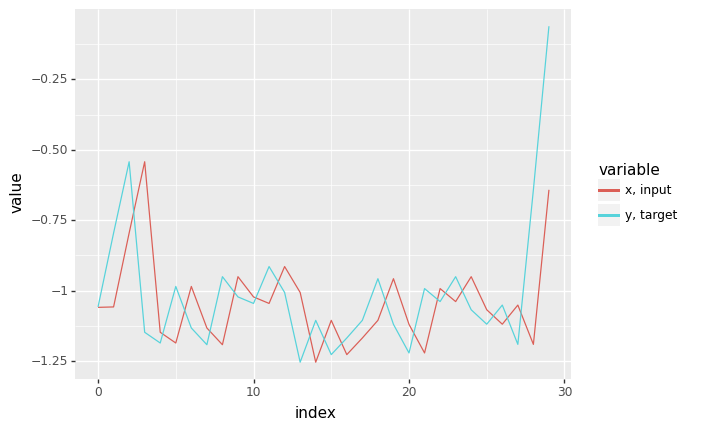

In [312]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off], 
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

In [313]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    # model = hk.GRU(HIDDEN_SIZE)
    model = hk.DeepRNN([
        hk.GRU(HIDDEN_SIZE),
        jax.nn.relu,
        hk.GRU(HIDDEN_SIZE)
    ])
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

def sequence_loss(batch: Batch, rng_key: jnp.ndarray, t_f_prob: jnp.float32) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    dense = hk.Linear(FEATURE_NUM)
    batch_size, sequence_length, _ = batch['input'].shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    _input = batch['input']  # (B, T, 1)

    # logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)  # (B, T, HIDDEN_SIZE)
    # logits_batched = hk.BatchApply(hk.Linear(FEATURE_NUM))(logits)  # (B, T, 1)

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        logit = v.logits[:, t, :]  # (B, F)
        new_logit, new_state = core(logit, v.state)  # (B, HIDDEN_SIZE)
        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, 1, HIDDEN_SIZE))
        new_logit = hk.BatchApply(dense)(new_logit)
        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, FEATURE_NUM))

        # teacher forcing
        p = v.t_f_p
        _key, _subkey = jax.random.split(v.rng_key)
        t_f_replace = jax.random.choice(_subkey,
                jnp.array([1, 0], dtype=jnp.bool_), p = jnp.array([p, 1-p]))
        t_f_keep = jnp.invert(t_f_replace)

        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, FEATURE_NUM))
        t_f_logit = new_logit*t_f_replace + _input[:, t+1, :]*t_f_keep
        new_logits = v.logits.at[:, t + 1, :].set(t_f_logit)
        return LoopValues(logits=new_logits, state=new_state, rng_key=_key, t_f_p=p)

    output_seq = jnp.zeros((BATCH_SIZE, BLOCK_SIZE, FEATURE_NUM))
    output_seq = output_seq.at[:, 0, :].set(_input[:, 0, :])
    initial_values = LoopValues(logits=output_seq, state=initial_state,
                                rng_key=rng_key, t_f_p=t_f_prob)
    lv: LoopValues = hk.fori_loop(0, BLOCK_SIZE, body_fn, initial_values)

    loss = jnp.mean(jnp.abs(batch['target'] - lv.logits))  # MAE
    return loss

@jax.jit
def update(state: TrainingState, batch: Batch, rng_key: jnp.array) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch, rng_key, state.t_f_p)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state, t_f_p=state.t_f_p)

def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()
    dense = hk.Linear(FEATURE_NUM)

    batch_size, sequence_length, _ = context.shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    # _input = jnp.expand_dims(context, -1)  # (B, T, 1)
    _input = jnp.reshape(context, (BLOCK_SIZE, 1, 1))

    context_outs, _state = hk.dynamic_unroll(core, _input, initial_state)  # (T, 1, HIDDEN_SIZE)

    context_outs = hk.BatchApply(dense)(context_outs)

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        logit = v.logits[t]
        new_logit, new_state = core(logit, v.state)  # (1, HIDDEN_SIZE)
        new_logit = dense(new_logit)
        new_logits = v.logits.at[t+1].set(new_logit)
        return LoopValues(logits=new_logits, state=new_state, rng_key=jnp.array([]), t_f_p=.0)

    output_seq = jnp.zeros((seq_len - sequence_length, 1, FEATURE_NUM))
    output_seq = output_seq.at[0].set(context_outs[0])
    initial_values = LoopValues(logits=output_seq, state=initial_state, rng_key=jnp.array([]), t_f_p=.0)
    lv: LoopValues = hk.fori_loop(0, seq_len - sequence_length, body_fn, initial_values)
    return jnp.concatenate([context_outs, lv.logits])

In [314]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
loss_fn = jax.jit(loss_fn)
initial_params = init_params_fn(next(rng), expl_batch, next(rng), .0)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state, t_f_p=.0)

In [315]:
def train(state):
    train_loss_all = jnp.array([])
    eval_loss_all = jnp.array([])

    for step in range(NUM_TRAINING_STEPS):
        _key = next(rng)
        train_batch = next(train_di)
        state = update(state, train_batch, _key)

        if step % EVAL_INTERVAL == 0:
            eval_batch = next(train_di)
            train_loss = loss_fn(state.params, train_batch, _key, state.t_f_p)
            eval_loss = loss_fn(state.params, eval_batch, _key, state.t_f_p)
            train_loss_all = jnp.append(train_loss_all, train_loss)
            eval_loss_all = jnp.append(eval_loss_all, eval_loss)
            print({
                'step': step,
                'train_loss': float(train_loss),
                'eval_loss': float(eval_loss),
                'TF': float(state.t_f_p)
            })

            # TF
            state = TrainingState(state.params, state.opt_state, state.t_f_p + .01)

    return state, train_loss_all, eval_loss_all

final_state, train_loss_arr, eval_loss_arr = train(state)

{'step': 0, 'train_loss': 0.13360480964183807, 'eval_loss': 0.14560633897781372, 'TF': 0.0}
{'step': 10, 'train_loss': 0.1650596410036087, 'eval_loss': 0.16054750978946686, 'TF': 0.009999999776482582}
{'step': 20, 'train_loss': 0.15164446830749512, 'eval_loss': 0.18065379559993744, 'TF': 0.019999999552965164}
{'step': 30, 'train_loss': 0.17160692811012268, 'eval_loss': 0.15414828062057495, 'TF': 0.029999999329447746}
{'step': 40, 'train_loss': 0.19680817425251007, 'eval_loss': 0.15901120007038116, 'TF': 0.03999999910593033}
{'step': 50, 'train_loss': 0.17525668442249298, 'eval_loss': 0.1587590128183365, 'TF': 0.04999999701976776}
{'step': 60, 'train_loss': 0.16039955615997314, 'eval_loss': 0.1692667454481125, 'TF': 0.059999994933605194}
{'step': 70, 'train_loss': 0.16884657740592957, 'eval_loss': 0.18150480091571808, 'TF': 0.06999999284744263}
{'step': 80, 'train_loss': 0.17176267504692078, 'eval_loss': 0.18693630397319794, 'TF': 0.07999999076128006}
{'step': 90, 'train_loss': 0.169847

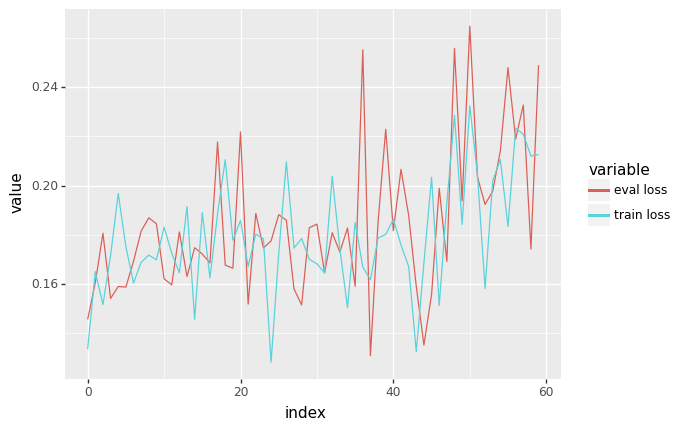

In [316]:
plot = utils.plot_samples(
    truth=train_loss_arr,
    prediction=eval_loss_arr,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [317]:
_, generate_fn = hk.without_apply_rng(hk.transform(generate))
predict = jax.jit(generate_fn, static_argnums=2)

In [318]:
val_batch = next(test_di)
context = val_batch["input"][:1, :]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE*2 )

In [319]:
predicted.shape, val_batch["target"].shape

((576, 1, 1), (8, 288, 1))

In [320]:
print(f" MAE: {jnp.mean(jnp.abs(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")

 MAE: 0.1506
 MSE: 0.0783


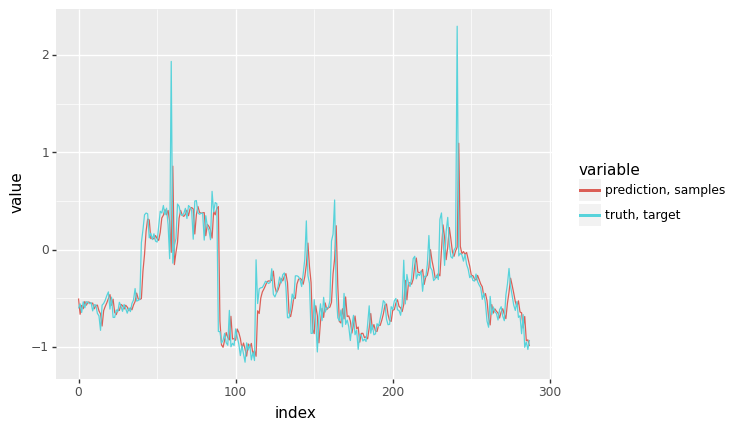

In [321]:
plot = utils.plot_samples(
    val_batch["target"][0, :, -1],
    predicted[:BLOCK_SIZE, -1, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()

In [322]:
data_wider_range = dl.test_ds[('uci', 'ftj')][0:2]
context = data_wider_range[0]["input"][:1]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE*2)
predicted.shape

(576, 1, 1)

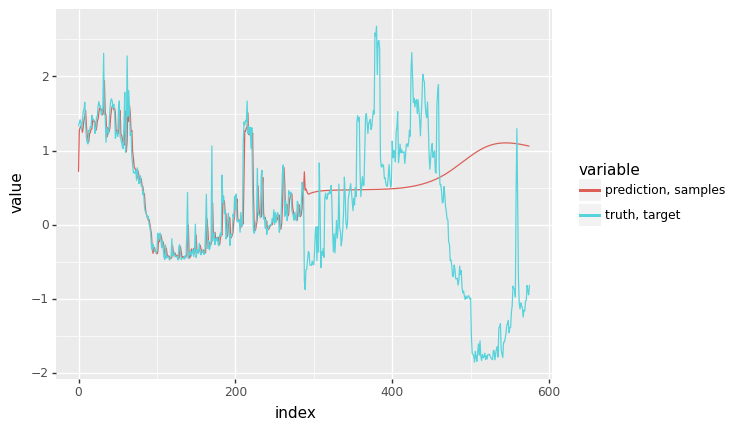

In [323]:
plot = utils.plot_samples(
    jnp.append(data_wider_range[0]["target"][0], data_wider_range[1]["target"][0]),
    predicted[:, -1, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()